In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=19cec24a05c91507f24d02306ba7a0ed021833fce5686e74dfa8cac11b2341cf
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline
import plotly.express as px
import time

from sklearn.preprocessing import LabelEncoder
#evaluation and feature engineering
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from datetime import datetime, date

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Install the kaggle library using pip
! pip install kaggle

# Creat a new directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the Bank Fraud Detection Dataset
!kaggle datasets download -d kartik2112/fraud-detection

100% 201M/202M [00:06<00:00, 29.3MB/s]
100% 202M/202M [00:06<00:00, 33.5MB/s]


In [5]:
# Create a new directory inside My Drive
!mkdir -p "/content/drive/My Drive/fraud-detection/"

# Copy the 'fraud-detection.zip' file to the 'fraud-detection' directory
!cp fraud-detection.zip "/content/drive/My Drive/fraud-detection/"

In [6]:
# Unzip the bank fraud detection dataset file
!unzip "/content/drive/My Drive/fraud-detection/fraud-detection.zip"

Archive:  /content/drive/My Drive/fraud-detection/fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [7]:
# Read the bank fraud dataset into a DataFrame
df = pd.read_csv('fraudTrain.csv')

# Check data information for Bank fraud dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
# Check the first 5 rows of the dataset
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [9]:
# Check Summary statistics
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [10]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)



Missing values before treatment:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [11]:
import numpy as np
# Check for positive or negative infinity in the DataFrame.
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [12]:
# Select a fraction of the dataset as sample size
df = df.sample(frac=0.3) # Get 30% of the data
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389002 entries, 259165 to 313809
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             389002 non-null  int64  
 1   trans_date_trans_time  389002 non-null  object 
 2   cc_num                 389002 non-null  int64  
 3   merchant               389002 non-null  object 
 4   category               389002 non-null  object 
 5   amt                    389002 non-null  float64
 6   first                  389002 non-null  object 
 7   last                   389002 non-null  object 
 8   gender                 389002 non-null  object 
 9   street                 389002 non-null  object 
 10  city                   389002 non-null  object 
 11  state                  389002 non-null  object 
 12  zip                    389002 non-null  int64  
 13  lat                    389002 non-null  float64
 14  long                   389002 n

In [13]:
# Store the column names of 'df' in the variable 'cols'
cols= df.columns

# Import the LabelEncoder class from the scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Label encode categorical varaibles
le = LabelEncoder()
for i, cols in enumerate(df[df.iloc[:, 1:].columns]):
    df[cols]=le.fit_transform(df[cols])

In [14]:
# check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389002 entries, 259165 to 313809
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   Unnamed: 0             389002 non-null  int64
 1   trans_date_trans_time  389002 non-null  int64
 2   cc_num                 389002 non-null  int64
 3   merchant               389002 non-null  int64
 4   category               389002 non-null  int64
 5   amt                    389002 non-null  int64
 6   first                  389002 non-null  int64
 7   last                   389002 non-null  int64
 8   gender                 389002 non-null  int64
 9   street                 389002 non-null  int64
 10  city                   389002 non-null  int64
 11  state                  389002 non-null  int64
 12  zip                    389002 non-null  int64
 13  lat                    389002 non-null  int64
 14  long                   389002 non-null  int64
 15  city_pop    

In [15]:
cols= df.columns
from sklearn import preprocessing

# Initialize the MinMaxScaler.
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(df)
df = pd.DataFrame(minmax_df, columns =df.columns)


In [16]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0.199868,0.200007,0.795918,0.838150,0.692308,0.041351,0.700855,0.454167,0.0,0.368367,...,0.006218,0.186335,0.752283,0.484787,0.851813,0.541508,0.200009,0.004997,0.201874,0.0
1,0.048570,0.048914,0.129592,0.193642,0.000000,0.267804,0.324786,0.589583,1.0,0.180612,...,0.626943,0.298137,0.659817,0.484787,0.845596,0.974275,0.048914,0.564169,0.301072,0.0
2,0.504258,0.504936,0.966327,0.380058,0.000000,0.321269,0.031339,0.510417,0.0,0.645918,...,0.672539,0.494824,0.437215,0.758621,0.996891,0.187437,0.504938,0.744580,0.481364,0.0
3,0.263647,0.263770,0.630612,0.463873,0.153846,0.177547,0.321937,0.310417,1.0,0.928571,...,0.922280,0.350932,0.494292,0.091278,0.046632,0.497621,0.263772,0.881452,0.339927,0.0
4,0.617270,0.617916,0.620408,0.352601,0.692308,0.031755,0.242165,0.304167,0.0,0.000000,...,0.978238,0.034161,0.834475,0.657201,0.715026,0.561384,0.617917,0.987013,0.029882,0.0


In [17]:
# Seperate the feautures (input data) from the target variable.
X= df.drop(columns = 'is_fraud')
y= df['is_fraud']

In [18]:
X

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
0,0.199868,0.200007,0.795918,0.838150,0.692308,0.041351,0.700855,0.454167,0.0,0.368367,...,0.844881,0.006218,0.186335,0.752283,0.484787,0.851813,0.541508,0.200009,0.004997,0.201874
1,0.048570,0.048914,0.129592,0.193642,0.000000,0.267804,0.324786,0.589583,1.0,0.180612,...,0.551189,0.626943,0.298137,0.659817,0.484787,0.845596,0.974275,0.048914,0.564169,0.301072
2,0.504258,0.504936,0.966327,0.380058,0.000000,0.321269,0.031339,0.510417,0.0,0.645918,...,0.643226,0.672539,0.494824,0.437215,0.758621,0.996891,0.187437,0.504938,0.744580,0.481364
3,0.263647,0.263770,0.630612,0.463873,0.153846,0.177547,0.321937,0.310417,1.0,0.928571,...,0.585315,0.922280,0.350932,0.494292,0.091278,0.046632,0.497621,0.263772,0.881452,0.339927
4,0.617270,0.617916,0.620408,0.352601,0.692308,0.031755,0.242165,0.304167,0.0,0.000000,...,0.985522,0.978238,0.034161,0.834475,0.657201,0.715026,0.561384,0.617917,0.987013,0.029882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388997,0.263170,0.263258,0.717347,0.807803,0.153846,0.119584,0.304843,0.206250,0.0,0.687755,...,0.788004,0.237306,0.287785,0.393836,0.638945,0.507772,0.253724,0.263260,0.213560,0.311929
388998,0.391622,0.392208,0.324490,0.495665,0.769231,0.001799,0.558405,0.456250,0.0,0.618367,...,0.038263,0.750259,0.951346,0.204338,0.206897,0.796891,0.286806,0.392209,0.762192,0.969281
388999,0.606233,0.606890,0.853061,0.682081,0.307692,0.260518,0.800570,0.406250,1.0,0.443878,...,0.298862,0.157513,0.592133,0.553653,0.387424,0.454922,0.274477,0.606891,0.117762,0.616268
389000,0.813234,0.813861,0.898980,0.833815,0.769231,0.058592,0.586895,0.510417,0.0,0.557143,...,0.785936,0.312953,0.274327,0.961187,0.099391,0.440415,0.576978,0.813861,0.354332,0.270983


In [19]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
388997    0.0
388998    0.0
388999    0.0
389000    0.0
389001    0.0
Name: is_fraud, Length: 389002, dtype: float64

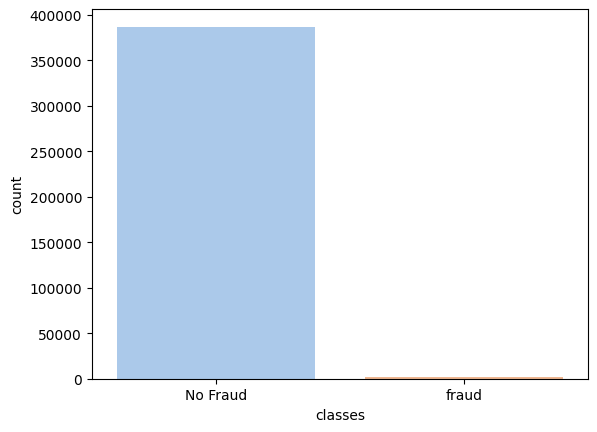

In [20]:
# Visualise to show level of class imbalance in Bank Credit Card Fraud Dataset
import seaborn as sns
label_class= df['is_fraud'].value_counts()
sns.barplot(x=['No Fraud','fraud',],y=label_class, palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [21]:
# Balance the dataset using TomekLink technique.
tl = TomekLinks(
     sampling_strategy='auto',
     n_jobs=4)

# Apply the NearMiss technique on the dataset (X and y).
X_resampled, y_resampled = tl.fit_resample(X, y)

In [22]:
# Add a new column named 'label' to the DataFrame `X_resampled`
X_resampled['label'] = y_resampled

In [23]:
# Check head using first five rows
X_resampled.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,label
0,0.199868,0.200007,0.795918,0.838150,0.692308,0.041351,0.700855,0.454167,0.0,0.368367,...,0.006218,0.186335,0.752283,0.484787,0.851813,0.541508,0.200009,0.004997,0.201874,0.0
1,0.048570,0.048914,0.129592,0.193642,0.000000,0.267804,0.324786,0.589583,1.0,0.180612,...,0.626943,0.298137,0.659817,0.484787,0.845596,0.974275,0.048914,0.564169,0.301072,0.0
2,0.504258,0.504936,0.966327,0.380058,0.000000,0.321269,0.031339,0.510417,0.0,0.645918,...,0.672539,0.494824,0.437215,0.758621,0.996891,0.187437,0.504938,0.744580,0.481364,0.0
3,0.263647,0.263770,0.630612,0.463873,0.153846,0.177547,0.321937,0.310417,1.0,0.928571,...,0.922280,0.350932,0.494292,0.091278,0.046632,0.497621,0.263772,0.881452,0.339927,0.0
4,0.617270,0.617916,0.620408,0.352601,0.692308,0.031755,0.242165,0.304167,0.0,0.000000,...,0.978238,0.034161,0.834475,0.657201,0.715026,0.561384,0.617917,0.987013,0.029882,0.0


In [24]:
# Save DataFrame to a CSV file
X_resampled.to_csv("file1.csv")

In [25]:
# Initiate the spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('empirical-evaluation').getOrCreate()
# read the CSV file into a Spark DataFrame
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: double (nullable = true)
 |-- trans_date_trans_time: double (nullable = true)
 |-- cc_num: double (nullable = true)
 |-- merchant: double (nullable = true)
 |-- category: double (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: double (nullable = true)
 |-- last: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- street: double (nullable = true)
 |-- city: double (nullable = true)
 |-- state: double (nullable = true)
 |-- zip: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: double (nullable = true)
 |-- job: double (nullable = true)
 |-- dob: double (nullable = true)
 |-- trans_num: double (nullable = true)
 |-- unix_time: double (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- label: double (nullable = true)



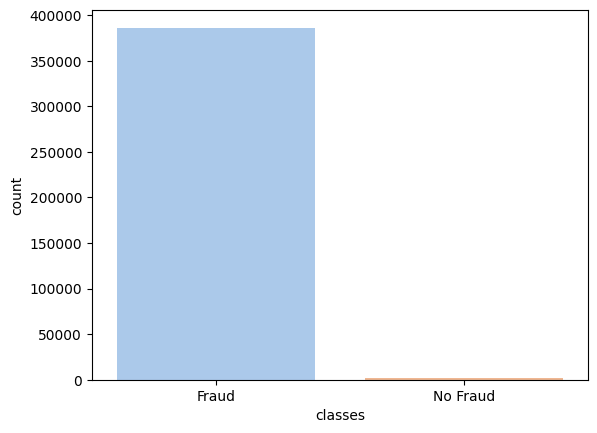

In [26]:
# Visualise to check level of imbalance
import seaborn as sns
label_class=df.groupBy('label').count().toPandas()
sns.barplot(x=['Fraud','No Fraud',],y=label_class['count'], palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [27]:
# Check summary statistics for each column
df.describe().toPandas()

,summary,_c0,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,label
0,count,388438,388438,388438,388438,388438,388438,388438,388438,388438,...,388438,388438,388438,388438,388438,388438,388438,388438,388438,388438
1,mean,194218.5,0.4997277288294191,0.5001575569389473,0.49994237779764006,0.49539564671749686,0.4785442444631384,0.17837359537728478,0.5135614891458189,0.5222913041034706,...,0.4981673617894061,0.49555082730505823,0.4892723017261492,0.5094574601785006,0.5513765441911909,0.5000089542633486,0.5001586441794151,0.5004246450231231,0.5003206958940877,0.005722921032442758
2,stddev,112132.53626921434,0.2885838992762665,0.2885917370816772,0.2870850989412526,0.29060939305500594,0.3010574725314018,0.1852257117795677,0.27806379844618945,0.28479493975988507,...,0.29142802764749154,0.288068184457082,0.3022635419607953,0.2840760556002139,0.2771132974929434,0.2886929931306547,0.2885913173692162,0.28814284695357945,0.28851119698308786,0.07543330733956304
3,min,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,388437,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.9999999999999999,1.0,1.0,1.0,1.0


In [28]:
# feature scaling and vector assembling
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [29]:
# Instantiate a 'VectorAssembler` object and transform
sel_cols = df.columns
assembler = VectorAssembler(inputCols = sel_cols,
                            outputCol = "features_vectorize")
data = assembler.transform(df)

In [30]:
# Select distinct values from the "label" column, order them in ascending order,
# and then collect the values into a list.
label_list = data.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()

In [31]:
# Quick inspection of the data using the first 5 rows
pd.DataFrame(data.take(5),columns=data.columns)

,_c0,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,label,features_vectorize
0,0,0.199868,0.200007,0.795918,0.838150,0.692308,0.041351,0.700855,0.454167,0.0,...,0.186335,0.752283,0.484787,0.851813,0.541508,0.200009,0.004997,0.201874,0.0,"[0.0, 0.19986781494400643, 0.2000067178775641,..."
1,1,0.048570,0.048914,0.129592,0.193642,0.000000,0.267804,0.324786,0.589583,1.0,...,0.298137,0.659817,0.484787,0.845596,0.974275,0.048914,0.564169,0.301072,0.0,"[1.0, 0.04856991039333923, 0.04891390006381984..."
2,2,0.504258,0.504936,0.966327,0.380058,0.000000,0.321269,0.031339,0.510417,0.0,...,0.494824,0.437215,0.758621,0.996891,0.187437,0.504938,0.744580,0.481364,0.0,"[2.0, 0.5042582251264203, 0.5049363481100801, ..."
3,3,0.263647,0.263770,0.630612,0.463873,0.153846,0.177547,0.321937,0.310417,1.0,...,0.350932,0.494292,0.091278,0.046632,0.497621,0.263772,0.881452,0.339927,0.0,"[3.0, 0.26364671885688457, 0.26376971115710274..."
4,4,0.617270,0.617916,0.620408,0.352601,0.692308,0.031755,0.242165,0.304167,0.0,...,0.034161,0.834475,0.657201,0.715026,0.561384,0.617917,0.987013,0.029882,0.0,"[4.0, 0.6172702783366895, 0.617915545943823, 0..."


In [32]:
# Split dataset into train and test
train, test = data.randomSplit([0.8, 0.2], seed = 12)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 310647
Test Dataset Count: 77791


In [33]:
# Group by 'label' column and count number of occurences
# Convert to a Pandas DataFrame for easier manipulation.
train_label=train.groupBy('label').count().toPandas()
test_label=test.groupBy('label').count().toPandas()

In [34]:
# extract the counts of each unique value in the 'label' column
# from both the train and test and combine in a single list.
items1=[i for i in train_label['count'].values]
items2=[i for i in test_label['count'].values]
items=items1+items2

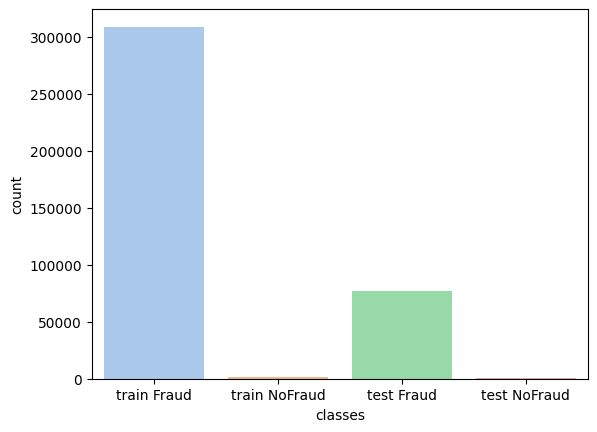

In [35]:
# Create a bar plot using seaborn.
classes=['train Fraud',"train NoFraud","test Fraud","test NoFraud"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=classes,y=items, palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()


Models Evaluation:
------------------------
Logistic Regression
now running Logistic Regression model
accuracy = 0.99
weightedPrecision = 0.99
weightedRecall = 0.99
f1 = 0.99
Decision Tree
now running Decision Tree model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Random Forest
now running Random Forest model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00
Naive Bayes Multinomial
now running Naive Bayes Multinomial model
accuracy = 1.00
weightedPrecision = 1.00
weightedRecall = 1.00
f1 = 1.00


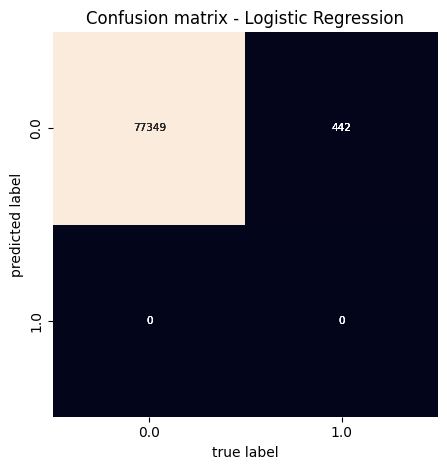

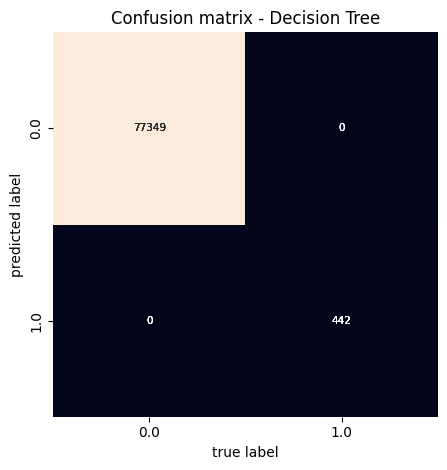

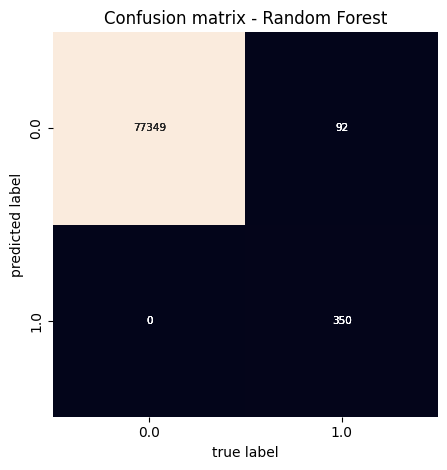

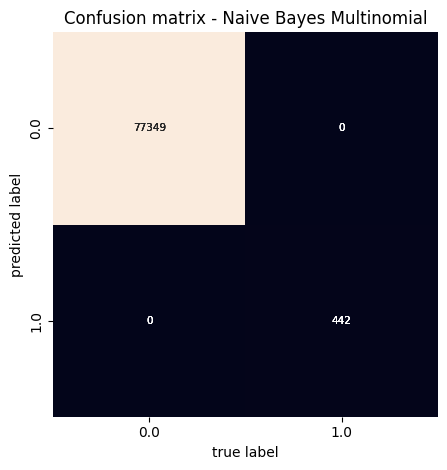

In [36]:
# Initialise Logistic Regression model with specified hyperparameters
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol = 'features_vectorize',
                        labelCol = 'label', family="multinomial")

# Initialise Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'features_vectorize', labelCol = 'label')

# Initialise Random Forest model with 20 trees
rf = RandomForestClassifier(labelCol="label", featuresCol='features_vectorize', numTrees=20)

# Initialise Naive Bayes Multinomial model
nb = NaiveBayes(labelCol="label", featuresCol='features_vectorize', smoothing=1.0, modelType="multinomial")

# Store models in a dictionary for easier iteration
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
               "Random Forest": rf, "Naive Bayes Multinomial": nb}

# Define evaluation metrics to be computed for each model
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

print("\nModels Evaluation:")
print("{:-<24}".format(""))

# Iterate through each classifier
for idx, c in enumerate(classifiers):
  print(c)

	# Fit the model on the training data
  print(f'now running {c} model')
  model = classifiers[c].fit(train)

  # Use the trained model to make predictions on the test data
  predictions = model.transform(test)
  predictions.cache()

  # Evaluate the performance of the model using PySpark's MulticlassClassificationEvaluator
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
  for m in metrics:
    evaluator.setMetricName(m)
    metric = evaluator.evaluate(predictions)
    print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn
    target_list = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    # print(classification_report(target_list, pred_list, target_names=label_list))

    # Compute and visualize the confusion matrix using seaborn
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
	            annot_kws={"size": 7.5}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()

# Display all the confusion matrix plots
plt.show()

In [37]:


#X_resampled, y_resampled = tl.fit_resample(X, y)

#nm2 = NearMiss(
 #   sampling_strategy='auto',  # undersamples only the majority class
  #  version=2)
#X_resampled, y_resampled = nm2.fit_resample(X, y)

#rus = RandomUnderSampler(sampling_strategy='auto',  # samples only the majority class
 #   random_state=0,  # for reproducibility
  #  replacement=True # if it should resample with replacement)
#X_resampled, y_resampled = rus.fit_resample(X, y)

#ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(X, y)